In [1]:
from __future__ import print_function
import numpy as np
import  pandas as pd
import matplotlib.pyplot as plt
import networkx as nx
import sys,os
import random
import copy
import warnings 

sys.path.append(os.path.abspath("/home/olya/SFU/Breast_cancer/DESMOND/"))

from desmond_io import print_network_stats

from simulations import make_bg_matrix, implant_biclusters, group_genes
from simulations import simulate_network, mapp_all_nodes, check_connectivity

from method import bicluster_avg_SNR, bicluster_corrs
from desmond_io import prepare_input_data
from find_optimal_parameters import read_DESMOND,read_true_bics

%matplotlib inline

N = 10 # n_bics
n_pats = 200
n_genes = 2000

g_sizes = [5,10,20,50,100] # 
p_sizes = [10,20,50,100] # 10-50% of the dataset
bic_median = 2.0 #
allow_gene_overlap = True
allow_patient_overlap = True

# network parameters
beta = 0.9
delta = 4.0

outdir = "simulated_datasets/"
basename = "simulated" #
n_bics=N


In [ ]:
network_outdir = "/networks_BFS/"
method = "BFS"

Simulate a matrix of (2000x200) (genesXpatients) expressions
Implant 10 (10x10) (genesXpatients) biclusters into the matrix;
Filename prefix:  simulated.N=10.Mu=2.0.GxP=10,10.overlap=TT
	gamma: 2.47368421053


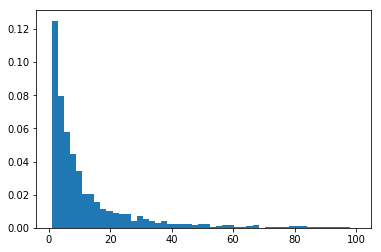

Undirected graph with 1 connected components; with 2000 nodes and 16157 edges;
	min and max node degree: 525,1
	Network created
	Max. number of biclusters per gene: 2
	Unique gene groups 13
	Genes grouped


runtime: 93.51 s


Grow independent networks 
Assing nodes for 10 gene(s) from [9] using BFS
	will consider no biclusters; de novo strating nodes identified 1730
	Grow CC [9] from any of 1730 nodes for 10 genes.
Assing nodes for 9 gene(s) from [8] using BFS
	will consider no biclusters; de novo strating nodes identified 1656
	Grow CC [8] from any of 1656 nodes for 9 genes.
Assing nodes for 9 gene(s) from [7] using BFS
	will consider no biclusters; de novo strating nodes identified 1639
	Grow CC [7] from any of 1639 nodes for 9 genes.
Assing nodes for 10 gene(s) from [6] using BFS
	will consider no biclusters; de novo strating nodes identified 1613
	Grow CC [6] from any of 1613 nodes for 10 genes.
Assing nodes for 10 gene(s) from [5] using BFS
	will consider no biclusters; de novo strating nodes identified 1586
	Grow CC [5] from any of 1586 nodes for 10 genes.
Assing nodes for 10 gene(s) from [4] using BFS
	will consider no biclusters; de novo strating nodes identified 1572
	Grow CC [4] from any of 1572 n

All nodes mapped: True


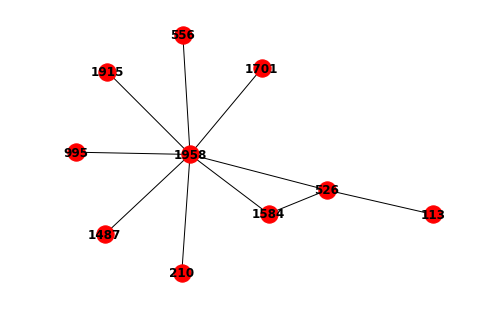

Undirected graph with 1 connected components; with 10 nodes and 10 edges;


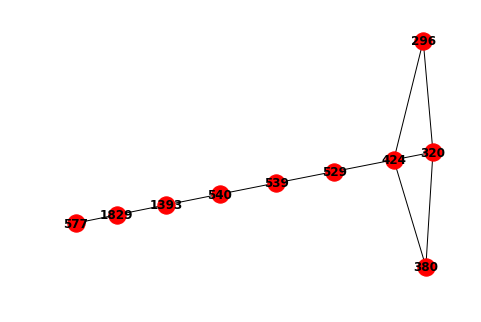

Undirected graph with 1 connected components; with 10 nodes and 11 edges;


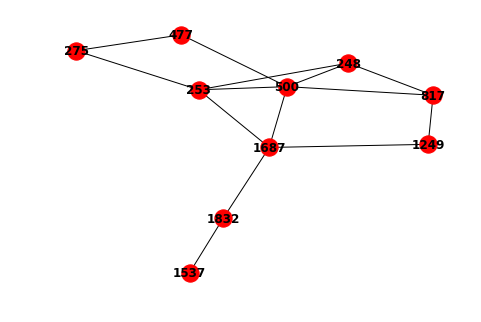

Undirected graph with 1 connected components; with 10 nodes and 14 edges;


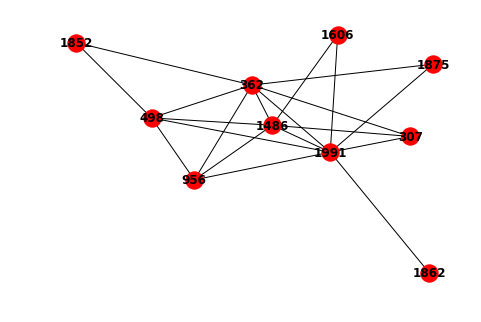

Undirected graph with 1 connected components; with 10 nodes and 20 edges;


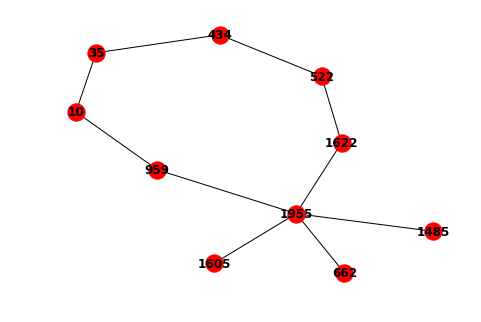

Undirected graph with 1 connected components; with 10 nodes and 10 edges;


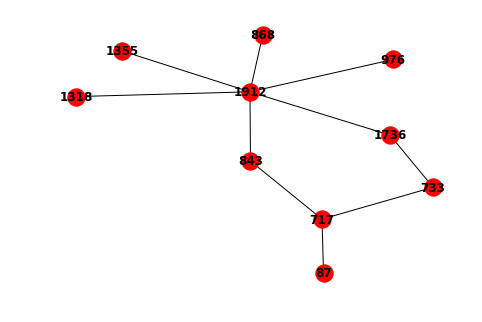

Undirected graph with 1 connected components; with 10 nodes and 10 edges;


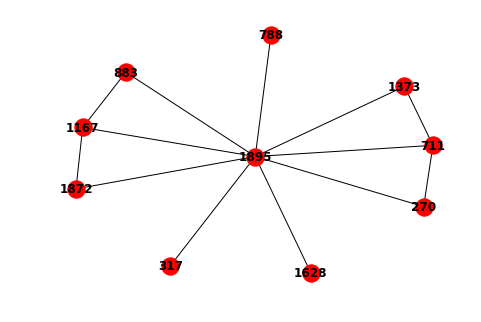

Undirected graph with 1 connected components; with 10 nodes and 13 edges;


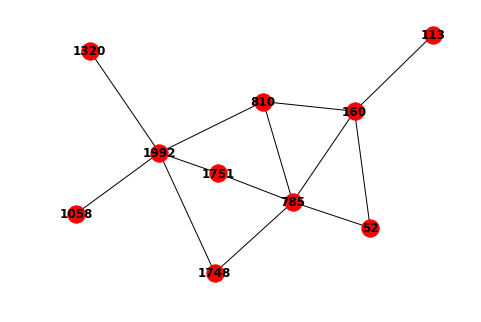

Undirected graph with 1 connected components; with 10 nodes and 13 edges;


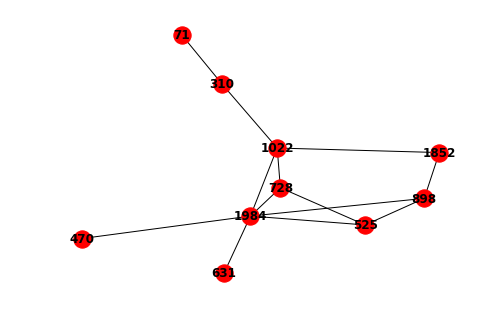

Undirected graph with 1 connected components; with 10 nodes and 13 edges;


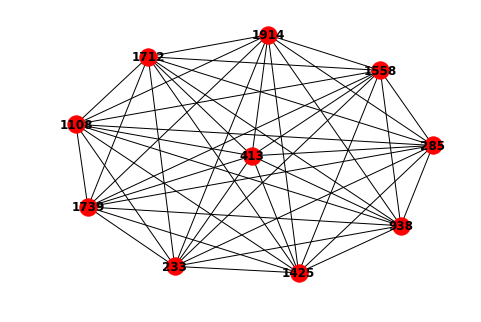

Undirected graph with 1 connected components; with 10 nodes and 45 edges;
	All subnetworks connected: True
Saved to simulated_datasets//networks_tmp/simulated.N=10.Mu=2.0.GxP=10,10.overlap=TT


IOError: [Errno 2] No such file or directory: 'simulated_datasets//networks_tmp/simulated.N=10.Mu=2.0.GxP=10,10.overlap=TT.gpickle'

In [3]:


for genes_per_bic in g_sizes:
    for pats_per_bic in p_sizes:    
        print("Simulate a matrix of (%sx%s) (genesXpatients) expressions"%(n_genes,n_pats))
        print("Implant %s (%sx%s) (genesXpatients) biclusters into the matrix;"%(N,genes_per_bic,pats_per_bic))
        
        prefix = basename+".N="+str(N)+".Mu="+str(bic_median)+".GxP="+str(genes_per_bic)+","+str(pats_per_bic)+".overlap=TT"
        filename = prefix
        print("Filename prefix: ",filename)
        df = pd.read_csv("simulated_datasets/exprs/"+prefix+".exprs.tsv",sep = "\t", index_col=0)
        anno = pd.read_csv("simulated_datasets/exprs_annotated/"+prefix+".exprs_annotated.tsv",sep = "\t", index_col=0)
        anno.index.rename(int,inplace=True)
        biclusters = read_true_bics("simulated_datasets/true_biclusters/"+prefix+".biclusters.txt")
        for bic in biclusters:
            bic["genes"] = map(int,bic["genes"])
        anno = anno.iloc[10:,:10]
        anno = anno.applymap(int)
        anno.index.name = "genes2biclusters"
        
        
        #print("\tAverage SNR for simulated biclusters:", round(avg_SNR(biclusters),2))
        
        # simulate network
        G = simulate_network(n_genes,beta, delta)
        #n_genes*math.log(n_genes,3)
        print("\tNetwork created")
        # group genes by bicluster membership; star from genes assigned to many biclusters
        gene_groups, max_bics_per_gene, anno = group_genes(anno,verbose = True)
        print("\tGenes grouped")
        # assign gene names to nodes such that each bicluster form a CC
        G2 = mapp_all_nodes(G,gene_groups,max_bics_per_gene, method=method, verbose=True)
        
        are_connected = check_connectivity(G2, anno,verbose=True,plot = True)
        print("\tAll subnetworks connected:",are_connected)
        network_file = outdir+network_outdir+filename
        print("Saved to",network_file)
        # clean node attributes in the network
        for node in G2.nodes():
            del G2.node[node]['bics']
        # save network
        nx.write_gpickle(G2,network_file+".gpickle")
        # save as weighted edgelist 
        nx.set_edge_attributes(G2, 'weight',1)
        nx.write_weighted_edgelist(G2, network_file+'.tab')
        # load network
        #G2 =  nx.read_gpickle(network_file)
        #G2.nodes() == G.nodes(), sorted(G2.edges()) == sorted(G.edges())
        print("")

### Depth-first search

In [ ]:
network_outdir = "/networks_DFS/"
method = "DFS"

Simulate a matrix of (2000x200) (genesXpatients) expressions
Implant 10 (10x10) (genesXpatients) biclusters into the matrix;
Filename prefix:  simulated.N=10.Mu=2.0.GxP=10,10.overlap=TT
	gamma: 2.47368421053


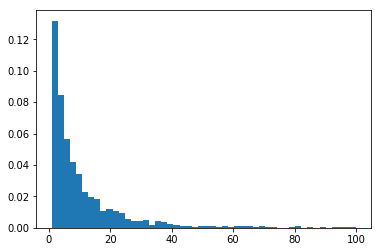

Undirected graph with 1 connected components; with 2000 nodes and 14452 edges;
	min and max node degree: 647,1
	Network created
	Max. number of biclusters per gene: 2
	Unique gene groups 13
	Genes grouped


runtime: 108.53 s


Grow independent networks 
Assing nodes for 10 gene(s) from [9] using BFS
	will consider no biclusters; de novo strating nodes identified 1716
	Grow CC [9] from any of 1716 nodes for 10 genes.
Assing nodes for 9 gene(s) from [8] using BFS
	will consider no biclusters; de novo strating nodes identified 1602
	Grow CC [8] from any of 1602 nodes for 9 genes.
Assing nodes for 9 gene(s) from [7] using BFS
	will consider no biclusters; de novo strating nodes identified 1582
	Grow CC [7] from any of 1582 nodes for 9 genes.
Assing nodes for 10 gene(s) from [6] using BFS
	will consider no biclusters; de novo strating nodes identified 1570
	Grow CC [6] from any of 1570 nodes for 10 genes.
Assing nodes for 10 gene(s) from [5] using BFS
	will consider no biclusters; de novo strating nodes identified 1559
	Grow CC [5] from any of 1559 nodes for 10 genes.
Assing nodes for 10 gene(s) from [4] using BFS
	will consider no biclusters; de novo strating nodes identified 1537
	Grow CC [4] from any of 1537 n

All nodes mapped: True


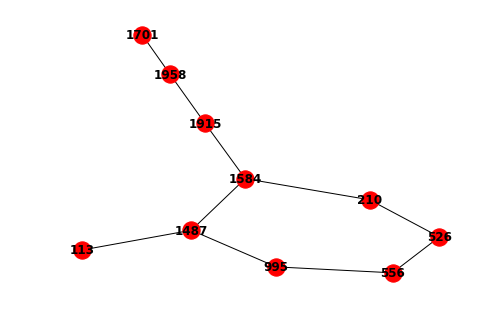

Undirected graph with 1 connected components; with 10 nodes and 10 edges;


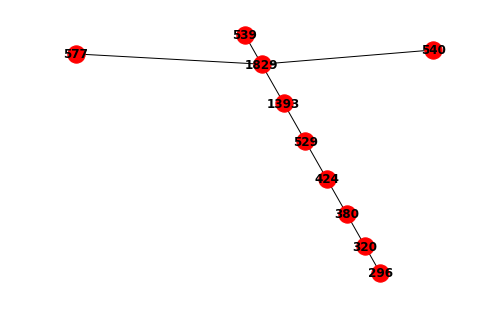

Undirected graph with 1 connected components; with 10 nodes and 9 edges;


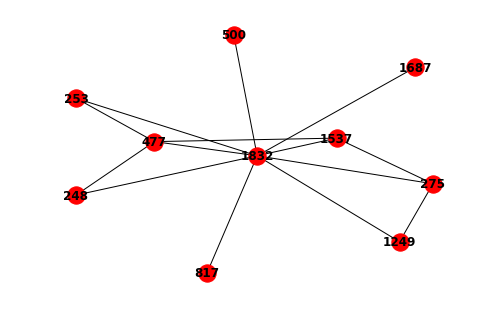

Undirected graph with 1 connected components; with 10 nodes and 14 edges;


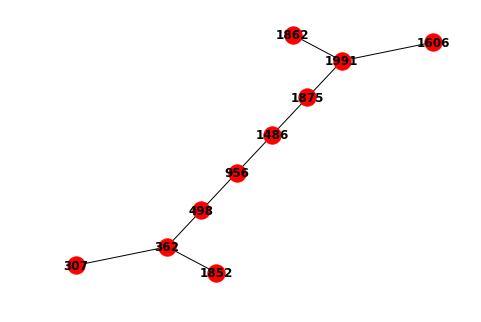

Undirected graph with 1 connected components; with 10 nodes and 9 edges;


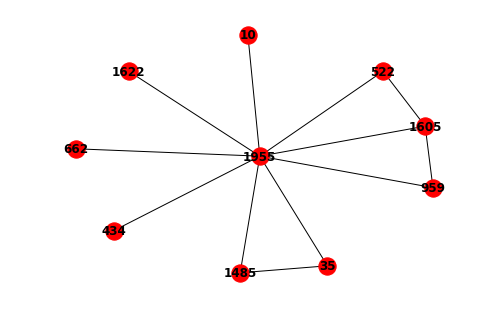

Undirected graph with 1 connected components; with 10 nodes and 12 edges;


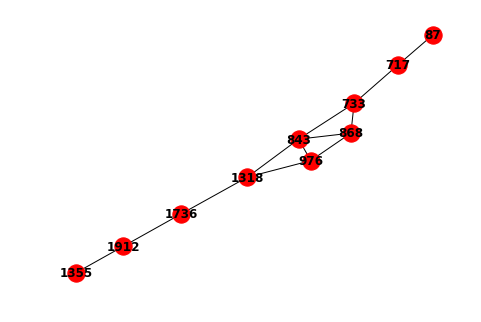

Undirected graph with 1 connected components; with 10 nodes and 12 edges;


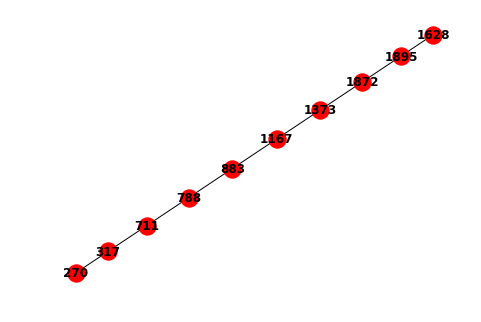

Undirected graph with 1 connected components; with 10 nodes and 9 edges;


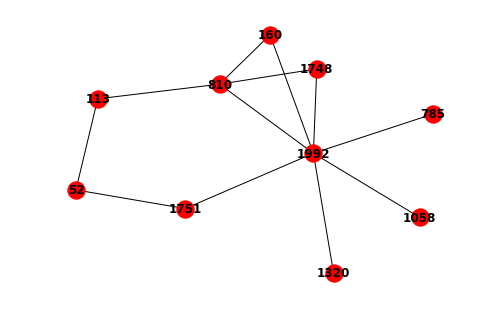

Undirected graph with 1 connected components; with 10 nodes and 12 edges;


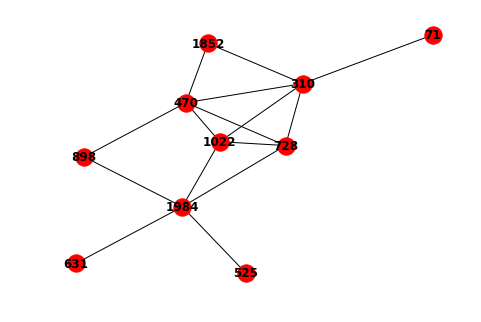

Undirected graph with 1 connected components; with 10 nodes and 15 edges;


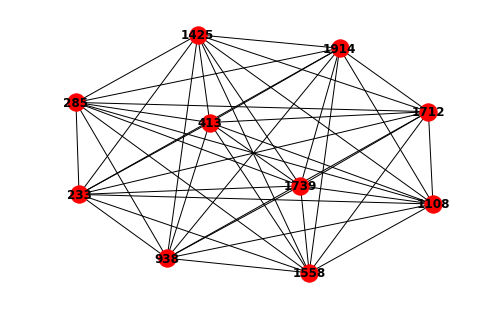

Undirected graph with 1 connected components; with 10 nodes and 45 edges;
	All subnetworks connected: True
Saved to simulated_datasets//networks_tmp/simulated.N=10.Mu=2.0.GxP=10,10.overlap=TT


IOError: [Errno 2] No such file or directory: 'simulated_datasets//networks_tmp/simulated.N=10.Mu=2.0.GxP=10,10.overlap=TT.gpickle'

In [5]:
for genes_per_bic in g_sizes:
    for pats_per_bic in p_sizes:    
        print("Simulate a matrix of (%sx%s) (genesXpatients) expressions"%(n_genes,n_pats))
        print("Implant %s (%sx%s) (genesXpatients) biclusters into the matrix;"%(N,genes_per_bic,pats_per_bic))
        
        prefix = basename+".N="+str(N)+".Mu="+str(bic_median)+".GxP="+str(genes_per_bic)+","+str(pats_per_bic)+".overlap=TT"
        filename = prefix
        print("Filename prefix: ",filename)
        df = pd.read_csv("simulated_datasets/exprs/"+prefix+".exprs.tsv",sep = "\t", index_col=0)
        anno = pd.read_csv("simulated_datasets/exprs_annotated/"+prefix+".exprs_annotated.tsv",sep = "\t", index_col=0)
        anno.index.rename(int,inplace=True)
        biclusters = read_true_bics("simulated_datasets/true_biclusters/"+prefix+".biclusters.txt")
        for bic in biclusters:
            bic["genes"] = map(int,bic["genes"])
        anno = anno.iloc[10:,:10]
        anno = anno.applymap(int)
        anno.index.name = "genes2biclusters"
        
        
        #print("\tAverage SNR for simulated biclusters:", round(avg_SNR(biclusters),2))
        
        # simulate network
        G = simulate_network(n_genes,beta, delta)
        #n_genes*math.log(n_genes,3)
        print("\tNetwork created")
        # group genes by bicluster membership; star from genes assigned to many biclusters
        gene_groups, max_bics_per_gene, anno = group_genes(anno,verbose = True)
        print("\tGenes grouped")
        # assign gene names to nodes such that each bicluster form a CC
        G2 = mapp_all_nodes(G,gene_groups,max_bics_per_gene, method=method, verbose=True)
        
        are_connected = check_connectivity(G2, anno,verbose=True,plot = True)
        print("\tAll subnetworks connected:",are_connected)
        network_file = outdir+network_outdir+filename
        print("Saved to",network_file)
        # clean node attributes in the network
        for node in G2.nodes():
            del G2.node[node]['bics']
        # save network
        nx.write_gpickle(G2,network_file+".gpickle")
        # save as weighted edgelist 
        nx.set_edge_attributes(G2, 'weight',1)
        nx.write_weighted_edgelist(G2, network_file+'.tab')
        # load network
        #G2 =  nx.read_gpickle(network_file)
        #G2.nodes() == G.nodes(), sorted(G2.edges()) == sorted(G.edges())
        print("")

### DIAMOnD Method 
https://journals.plos.org/ploscompbiol/article?id=10.1371/journal.pcbi.1004120

In [ ]:
network_outdir = "/networks_DIAMOnD/"
method = "DIAMOnD"


Simulate a matrix of (2000x200) (genesXpatients) expressions
Implant 10 (10x10) (genesXpatients) biclusters into the matrix;
Filename prefix:  simulated.N=10.Mu=2.0.GxP=10,10.overlap=TT
	gamma: 2.47368421053


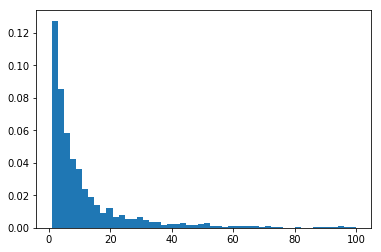

Undirected graph with 1 connected components; with 2000 nodes and 15321 edges;
	min and max node degree: 527,1
	Network created
	Max. number of biclusters per gene: 2
	Unique gene groups 13
	Genes grouped


runtime: 116.81 s


Grow independent networks 
Assing nodes for 10 gene(s) from [9] using BFS
	will consider no biclusters; de novo strating nodes identified 1709
	Grow CC [9] from any of 1709 nodes for 10 genes.
Assing nodes for 9 gene(s) from [8] using BFS
	will consider no biclusters; de novo strating nodes identified 1656
	Grow CC [8] from any of 1656 nodes for 9 genes.
Assing nodes for 9 gene(s) from [7] using BFS
	will consider no biclusters; de novo strating nodes identified 1634
	Grow CC [7] from any of 1634 nodes for 9 genes.
Assing nodes for 10 gene(s) from [6] using BFS
	will consider no biclusters; de novo strating nodes identified 1604
	Grow CC [6] from any of 1604 nodes for 10 genes.
Assing nodes for 10 gene(s) from [5] using BFS
	will consider no biclusters; de novo strating nodes identified 1577
	Grow CC [5] from any of 1577 nodes for 10 genes.
Assing nodes for 10 gene(s) from [4] using BFS
	will consider no biclusters; de novo strating nodes identified 1555
	Grow CC [4] from any of 1555 n

All nodes mapped: True


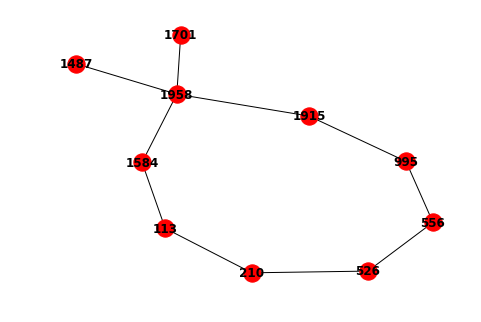

Undirected graph with 1 connected components; with 10 nodes and 10 edges;


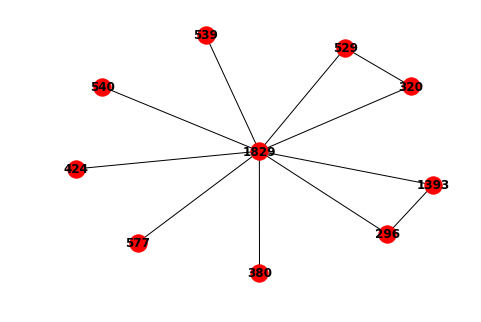

Undirected graph with 1 connected components; with 10 nodes and 11 edges;


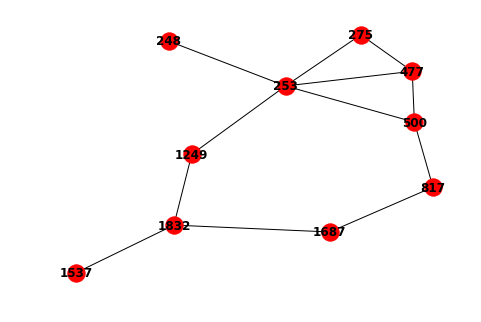

Undirected graph with 1 connected components; with 10 nodes and 12 edges;


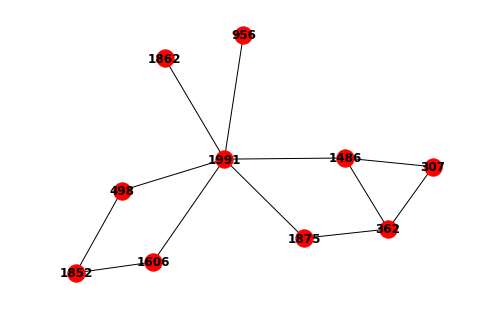

Undirected graph with 1 connected components; with 10 nodes and 12 edges;


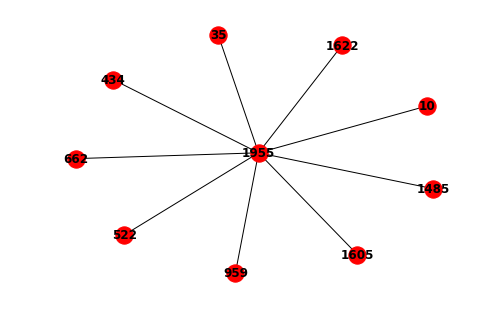

Undirected graph with 1 connected components; with 10 nodes and 9 edges;


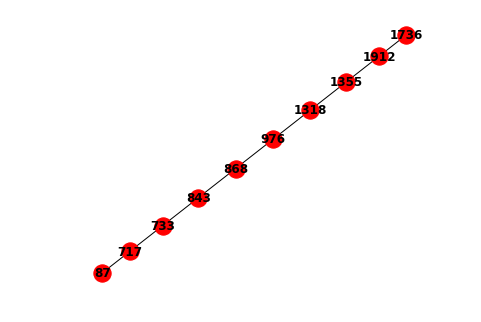

Undirected graph with 1 connected components; with 10 nodes and 9 edges;


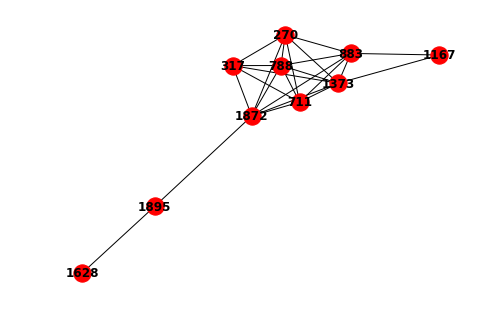

Undirected graph with 1 connected components; with 10 nodes and 24 edges;


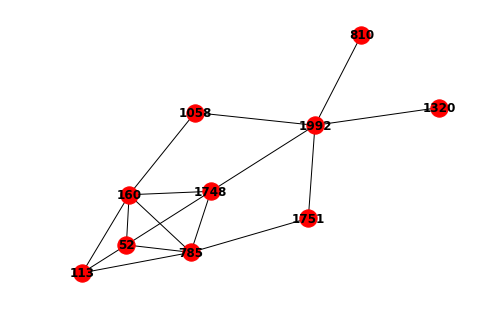

Undirected graph with 1 connected components; with 10 nodes and 16 edges;


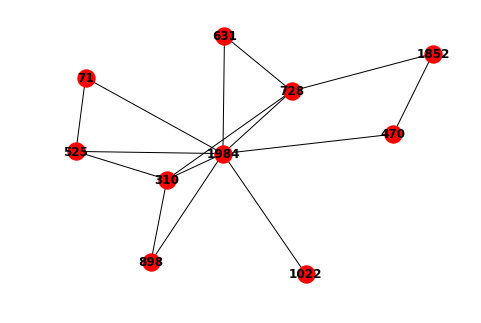

Undirected graph with 1 connected components; with 10 nodes and 15 edges;


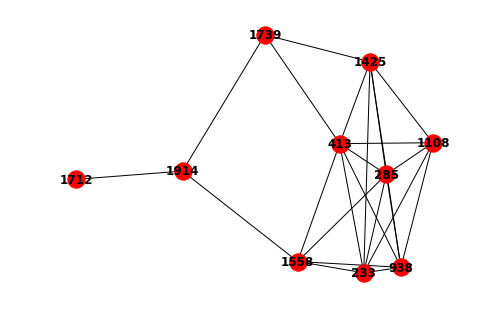

Undirected graph with 1 connected components; with 10 nodes and 24 edges;
	All subnetworks connected: True
Saved to simulated_datasets//networks_tmp/simulated.N=10.Mu=2.0.GxP=10,10.overlap=TT


IOError: [Errno 2] No such file or directory: 'simulated_datasets//networks_tmp/simulated.N=10.Mu=2.0.GxP=10,10.overlap=TT.gpickle'

In [6]:
for genes_per_bic in g_sizes:
    for pats_per_bic in p_sizes:    
        print("Simulate a matrix of (%sx%s) (genesXpatients) expressions"%(n_genes,n_pats))
        print("Implant %s (%sx%s) (genesXpatients) biclusters into the matrix;"%(N,genes_per_bic,pats_per_bic))
        
        prefix = basename+".N="+str(N)+".Mu="+str(bic_median)+".GxP="+str(genes_per_bic)+","+str(pats_per_bic)+".overlap=TT"
        filename = prefix
        print("Filename prefix: ",filename)
        df = pd.read_csv("simulated_datasets/exprs/"+prefix+".exprs.tsv",sep = "\t", index_col=0)
        anno = pd.read_csv("simulated_datasets/exprs_annotated/"+prefix+".exprs_annotated.tsv",sep = "\t", index_col=0)
        anno.index.rename(int,inplace=True)
        biclusters = read_true_bics("simulated_datasets/true_biclusters/"+prefix+".biclusters.txt")
        for bic in biclusters:
            bic["genes"] = map(int,bic["genes"])
        anno = anno.iloc[10:,:10]
        anno = anno.applymap(int)
        anno.index.name = "genes2biclusters"
        
        
        #print("\tAverage SNR for simulated biclusters:", round(avg_SNR(biclusters),2))
        
        # simulate network
        G = simulate_network(n_genes,beta, delta)
        #n_genes*math.log(n_genes,3)
        print("\tNetwork created")
        # group genes by bicluster membership; star from genes assigned to many biclusters
        gene_groups, max_bics_per_gene, anno = group_genes(anno,verbose = True)
        print("\tGenes grouped")
        # assign gene names to nodes such that each bicluster form a CC
        G2 = mapp_all_nodes(G,gene_groups,max_bics_per_gene, method=method, verbose=True)
        
        are_connected = check_connectivity(G2, anno,verbose=True,plot = True)
        print("\tAll subnetworks connected:",are_connected)
        network_file = outdir+network_outdir+filename
        print("Saved to",network_file)
        # clean node attributes in the network
        for node in G2.nodes():
            del G2.node[node]['bics']
        # save network
        nx.write_gpickle(G2,network_file+".gpickle")
        # save as weighted edgelist 
        nx.set_edge_attributes(G2, 'weight',1)
        nx.write_weighted_edgelist(G2, network_file+'.tab')
        # load network
        #G2 =  nx.read_gpickle(network_file)
        #G2.nodes() == G.nodes(), sorted(G2.edges()) == sorted(G.edges())
        print("")